In [ ]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random



> 구글 드라이브 연동



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




> 데이터셋 불러오기



In [ ]:
data_path = '/content/drive/MyDrive/ML/plant-pathology-2020-fgvc7/'

train_set = pd.read_csv(data_path + 'train.csv')
test_set = pd.read_csv(data_path + 'test.csv')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
train_set = pd.read_csv(data_path + 'train.csv', index_col=0)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(train_set, 
                            test_size=0.2,
                            stratify=train_set[['healthy', 'multiple_diseases', 'rust', 'scab']],
                            random_state=42)

healthy_v = valid_set.loc[valid_set['healthy']==1]
multiple_diseases_v = valid_set.loc[valid_set['multiple_diseases']==1]
rust_v = valid_set.loc[valid_set['rust']==1]
scab_v = valid_set.loc[valid_set['scab']==1]

In [ ]:
import shutil
import os
from shutil import copyfile

if os.path.exists(data_path+'temp/'):
    shutil.rmtree(data_path+'temp/')

os.mkdir(data_path+'temp/')

# train directory
os.mkdir(data_path+'temp/train')
os.mkdir(data_path+'temp/train/healthy')
os.mkdir(data_path+'temp/train/multiple_diseases')
os.mkdir(data_path+'temp/train/rust')
os.mkdir(data_path+'temp/train/scab')

# validation directory
os.mkdir(data_path+'temp/valid')
os.mkdir(data_path+'temp/valid/healthy')
os.mkdir(data_path+'temp/valid/multiple_diseases')
os.mkdir(data_path+'temp/valid/rust')
os.mkdir(data_path+'temp/valid/scab')



> 데이터 수 확인

 : multiple_disease의 수가 적은 것을 확인, 해당 이미지의 수를 늘림



In [ ]:
SOURCE = data_path+'images/'

TRAIN_DIR = data_path+'temp/train/'

for index, data in train_set.iterrows():
    label = train_set.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy 413
multiple_diseases 73
rust 497
scab 473


In [ ]:
VALID_DIR = data_path+'temp/valid/'

for index, data in valid_set.iterrows():
    label = train_set.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))

healthy 103
multiple_diseases 18
rust 125
scab 119


In [ ]:
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps    

num_augmented_images = 350

file_path = data_path+'temp/train/multiple_diseases/'
file_names = os.listdir(file_path)
total_origin_image_num = len(file_names)
augment_cnt = 1

for i in range(1, num_augmented_images):
    change_picture_index = random.randrange(1, total_origin_image_num-1)
    file_name = file_names[change_picture_index]
    
    origin_image_path =  data_path+'temp/train/multiple_diseases/' + file_name
    image = Image.open(origin_image_path)
    random_augment = random.randrange(1,3)
    
    if(random_augment == 1):
        augment1_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        augment1_image = augment1_image.rotate(random.randrange(-20, 20))
        augment1_image.save(file_path+ str(augment_cnt) + '.jpg')
        
    elif(random_augment == 2):
        augment2_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        augment2_image = augment2_image.rotate(random.randrange(-20, 20))
        augment2_image.save(file_path + str(augment_cnt) + '.jpg')
        
    augment_cnt += 1

In [ ]:
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy 413
multiple_diseases 422
rust 497
scab 473


In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(224, 224), class_mode='categorical', batch_size=32)

Found 1805 images belonging to 4 classes.
Found 365 images belonging to 4 classes.




> callback 함수

  - 10번동안 val_accuracy가 좋아지지 않는다면 learning rate를 줄인다.
  - 20번동안 val_loss가 좋아지지 않는다면 멈춘다.



In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=10,
                            min_lr=.000001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)



> 모델 구현 및 학습



In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
#64개 필터 적용 / 필터 사이즈 3x3 / input_shape(행, 열, 색상:rgb)
model.add(MaxPooling2D((2, 2), padding='SAME'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='SAME'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='SAME'))
model.add(Dropout(.5))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='SAME'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='SAME'))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)

history = model.fit(train_generator, 
                    epochs=80, 
                    steps_per_epoch=56, 
                    validation_data = validation_generator,
                    validation_steps=12, 
                    callbacks=[LR_reduce, ES_monitor, checkpoint_cb])

Epoch 1/80
56/56 [==============================] - 120s 2s/step - loss: 1.9976 - accuracy: 0.3012 - val_loss: 1.4894 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 2/80
56/56 [==============================] - 106s 2s/step - loss: 1.7132 - accuracy: 0.3418 - val_loss: 1.5465 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 3/80
56/56 [==============================] - 106s 2s/step - loss: 1.2983 - accuracy: 0.4349 - val_loss: 1.2775 - val_accuracy: 0.3589 - lr: 0.0010
Epoch 4/80
56/56 [==============================] - 107s 2s/step - loss: 1.2004 - accuracy: 0.4738 - val_loss: 1.4542 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 5/80
56/56 [==============================] - 107s 2s/step - loss: 1.1468 - accuracy: 0.4755 - val_loss: 2.4405 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 6/80
56/56 [==============================] - 105s 2s/step - loss: 0.9539 - accuracy: 0.5950 - val_loss: 2.2928 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 7/80
56/56 [==============================] - 105s 2s/step - loss: 0.7

In [ ]:
model = keras.models.load_model("cnn.h5")



> 정확도 측정

 - accuracy 그래프
 - confusion metrix<br>
    : 이떄, multiple disease에 대해서는 잘 구별하지 못하는 모습을 보여주지만 전체적으로 정확도는 나쁘지 않음.



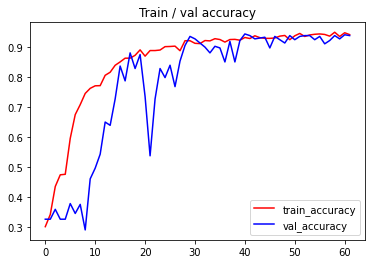

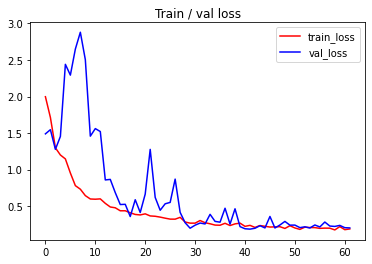

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='train_accuracy')
plt.plot(epochs, val_accuracy, 'b', label='val_accuracy')
plt.title('Train / val accuracy')
plt.legend(loc=0)
plt.show()

plt.plot(epochs, loss, 'r', label='train_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Train / val loss')
plt.legend(loc=0)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def accuracy(y, y_pred):
    return np.sum(y == y_pred)/len(y)

def plot_confusion_matrix(cm, labels=None, title='Confusion Matrix'):
    import plotly.figure_factory as ff

    x = labels
    y = x

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in cm]

    # set up figure 
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='YlGnBu', showscale=True)

    # add title
    fig.update_layout(title_text=title,
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=100, l=200), width=700, height=600)
    fig.show()

validation_generator = validation_datagen.flow_from_directory(VALID_DIR, 
                                                                target_size=(224, 224), 
                                                                class_mode='categorical', 
                                                                batch_size=32,
                                                                shuffle=False)
    
# predict labels from validation set
y_pred = model.predict(validation_generator)
# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 

valid_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_true = validation_generator.classes

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) 

plot_confusion_matrix(cm, labels, title='Confusion_matrix Validation Set (acc={:.3f})'.format(accuracy(y_true, y_pred)))

Found 365 images belonging to 4 classes.
